In [2]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
df = pd.read_csv('multivariate_eng_df.csv', parse_dates=['Date']).drop(columns=['Unnamed: 0'])

Importing plotly failed. Interactive plots will not work.


In [3]:
#separate df for california -- multivariate still
ca_df = df.loc[df['PROVINCE_STATE_NAME'] == 'California']
ca_df.drop(columns = ['STATE', 'PROVINCE_STATE_NAME'], inplace = True)
ca_df.head(3)

,Date,Completeness_pct,Administered_Dose1_Recip,Administered_Dose1_Recip_5Plus,Administered_Dose1_Recip_12Plus,Administered_Dose1_Recip_18Plus,Administered_Dose1_Recip_65Plus,Series_Complete_Yes,Series_Complete_5Plus,Series_Complete_5to17,...,vaccination_rate_complete,booster_rate,prop_age04,prop_age59,prop_age6064,prop_age8084,prop_age85plus,AGE04_29_TOT,AGE30_59_TOT,AGE60PLUS_TOT
0,2020-03-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.744418,6.165309,5.818187,1.71647,1.860398,13077768,15818572,8169914
1,2020-03-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.744418,6.165309,5.818187,1.71647,1.860398,13077768,15818572,8169914
2,2020-03-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.744418,6.165309,5.818187,1.71647,1.860398,13077768,15818572,8169914


In [4]:
#separate train & test sets
train_size = int(len(ca_df)* 0.85)
ca_train, ca_test = ca_df[0:train_size], ca_df[train_size:]

In [5]:
#identify best features among 179 using PCA -- to help speed up 
X_ca_train = ca_train.drop(columns=['PEOPLE_POSITIVE_NEW_CASES_COUNT']) 
X_ca_test = ca_test.drop(columns=['PEOPLE_POSITIVE_NEW_CASES_COUNT']) 
y_ca_train = ca_train['PEOPLE_POSITIVE_NEW_CASES_COUNT']
y_ca_test = ca_test['PEOPLE_POSITIVE_NEW_CASES_COUNT']

# Keep the 'Date' column separate and not to be scaled or PCA-transformed
Date_train = X_ca_train[['Date']].reset_index(drop=True)
Date_test = X_ca_test[['Date']].reset_index(drop=True)

# Exclude the 'Date' column from scaling and PCA
X_train_ca_numerical = X_ca_train.drop(columns=['Date'])
X_test_ca_numerical = X_ca_test.drop(columns=['Date'])


#standardize the features (mean=0 and variance=1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_ca_numerical)
X_test_scaled = scaler.fit_transform(X_test_ca_numerical)

#PCA to reduce the features to the top 40 principal components
pca = PCA(n_components=40)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.fit_transform(X_test_scaled)

#transformed data `X_pca` has only the top 40 principal components now
X_train_pca_df = pd.DataFrame(data = X_train_pca)
X_test_pca_df = pd.DataFrame(data = X_test_pca)

# Concatenate the PCA components with the 'Date' column
X_train_final = pd.concat([Date_train, X_train_pca_df], axis=1)
X_test_final = pd.concat([Date_test, X_test_pca_df], axis=1)

In [6]:
#forward selection algorithm to determine optimal feature combination for multivariate prophet model
target_column = 'PEOPLE_POSITIVE_NEW_CASES_COUNT'

# Updated forward selection function to include target data as separate arguments
def forward_selection(train_df, test_df, y_train, y_test, target_column):
    train_df.columns = train_df.columns.astype(str)
    test_df.columns = test_df.columns.astype(str)

    features = [col for col in train_df.columns if col != 'Date']
    included_features = []
    best_mae = np.inf
    improvement = True
    
    while improvement and features:
        improvement = False
        for feature in features:
            test_features = included_features + [feature]
            
            # Initialize and setup Prophet model
            model = Prophet(yearly_seasonality=True, weekly_seasonality=True)
            for f in test_features:
                model.add_regressor(f, standardize=False)
                
            # Prepare training data
            train_data = train_df[['Date'] + test_features]
            train_data['y'] = y_train
            train_data = train_data.rename(columns={'Date': 'ds'})
            
            model.fit(train_data)
            
            # Prepare testing data
            test_data = test_df[['Date'] + test_features]
            test_data['y'] = y_test  # This line is not used for prediction but kept for consistency
            test_data = test_data.rename(columns={'Date': 'ds'})
            
            forecast = model.predict(test_data.drop(columns=['y']))
            
            # Evaluate the model
            mae = mean_absolute_error(y_test, forecast['yhat'])
            
            if mae < best_mae:
                best_feature = feature
                best_mae = mae
                improvement = True
                
        if improvement:
            included_features.append(best_feature)
            features.remove(best_feature)
            print(f"Added {best_feature} to the model, new best MAE: {best_mae}")
    
    print(f"Final features selected: {included_features}")
    return included_features

In [7]:
# Run the updated forward selection
selected_features = forward_selection(X_train_final, X_test_final, y_ca_train, y_ca_test, target_column)

23:17:36 - cmdstanpy - INFO - Chain [1] start processing
23:17:36 - cmdstanpy - INFO - Chain [1] done processing
23:17:37 - cmdstanpy - INFO - Chain [1] start processing
23:17:37 - cmdstanpy - INFO - Chain [1] done processing
23:17:37 - cmdstanpy - INFO - Chain [1] start processing
23:17:37 - cmdstanpy - INFO - Chain [1] done processing
23:17:38 - cmdstanpy - INFO - Chain [1] start processing
23:17:38 - cmdstanpy - INFO - Chain [1] done processing
23:17:38 - cmdstanpy - INFO - Chain [1] start processing
23:17:38 - cmdstanpy - INFO - Chain [1] done processing
23:17:38 - cmdstanpy - INFO - Chain [1] start processing
23:17:39 - cmdstanpy - INFO - Chain [1] done processing
23:17:39 - cmdstanpy - INFO - Chain [1] start processing
23:17:39 - cmdstanpy - INFO - Chain [1] done processing
23:17:39 - cmdstanpy - INFO - Chain [1] start processing
23:17:39 - cmdstanpy - INFO - Chain [1] done processing
23:17:40 - cmdstanpy - INFO - Chain [1] start processing
23:17:40 - cmdstanpy - INFO - Chain [1]

Added 2 to the model, new best MAE: 28766.783265783877


23:17:52 - cmdstanpy - INFO - Chain [1] done processing
23:17:52 - cmdstanpy - INFO - Chain [1] start processing
23:17:53 - cmdstanpy - INFO - Chain [1] done processing
23:17:53 - cmdstanpy - INFO - Chain [1] start processing
23:17:53 - cmdstanpy - INFO - Chain [1] done processing
23:17:53 - cmdstanpy - INFO - Chain [1] start processing
23:17:53 - cmdstanpy - INFO - Chain [1] done processing
23:17:54 - cmdstanpy - INFO - Chain [1] start processing
23:17:54 - cmdstanpy - INFO - Chain [1] done processing
23:17:54 - cmdstanpy - INFO - Chain [1] start processing
23:17:54 - cmdstanpy - INFO - Chain [1] done processing
23:17:55 - cmdstanpy - INFO - Chain [1] start processing
23:17:55 - cmdstanpy - INFO - Chain [1] done processing
23:17:55 - cmdstanpy - INFO - Chain [1] start processing
23:17:55 - cmdstanpy - INFO - Chain [1] done processing
23:17:56 - cmdstanpy - INFO - Chain [1] start processing
23:17:56 - cmdstanpy - INFO - Chain [1] done processing
23:17:56 - cmdstanpy - INFO - Chain [1] 

Added 7 to the model, new best MAE: 26395.39943857878


23:18:08 - cmdstanpy - INFO - Chain [1] done processing
23:18:08 - cmdstanpy - INFO - Chain [1] start processing
23:18:08 - cmdstanpy - INFO - Chain [1] done processing
23:18:09 - cmdstanpy - INFO - Chain [1] start processing
23:18:09 - cmdstanpy - INFO - Chain [1] done processing
23:18:09 - cmdstanpy - INFO - Chain [1] start processing
23:18:09 - cmdstanpy - INFO - Chain [1] done processing
23:18:09 - cmdstanpy - INFO - Chain [1] start processing
23:18:09 - cmdstanpy - INFO - Chain [1] done processing
23:18:10 - cmdstanpy - INFO - Chain [1] start processing
23:18:10 - cmdstanpy - INFO - Chain [1] done processing
23:18:10 - cmdstanpy - INFO - Chain [1] start processing
23:18:10 - cmdstanpy - INFO - Chain [1] done processing
23:18:10 - cmdstanpy - INFO - Chain [1] start processing
23:18:11 - cmdstanpy - INFO - Chain [1] done processing
23:18:11 - cmdstanpy - INFO - Chain [1] start processing
23:18:11 - cmdstanpy - INFO - Chain [1] done processing
23:18:11 - cmdstanpy - INFO - Chain [1] 

Added 5 to the model, new best MAE: 25272.8386340192


23:18:22 - cmdstanpy - INFO - Chain [1] done processing
23:18:22 - cmdstanpy - INFO - Chain [1] start processing
23:18:22 - cmdstanpy - INFO - Chain [1] done processing
23:18:22 - cmdstanpy - INFO - Chain [1] start processing
23:18:22 - cmdstanpy - INFO - Chain [1] done processing
23:18:23 - cmdstanpy - INFO - Chain [1] start processing
23:18:23 - cmdstanpy - INFO - Chain [1] done processing
23:18:23 - cmdstanpy - INFO - Chain [1] start processing
23:18:23 - cmdstanpy - INFO - Chain [1] done processing
23:18:23 - cmdstanpy - INFO - Chain [1] start processing
23:18:23 - cmdstanpy - INFO - Chain [1] done processing
23:18:24 - cmdstanpy - INFO - Chain [1] start processing
23:18:24 - cmdstanpy - INFO - Chain [1] done processing
23:18:24 - cmdstanpy - INFO - Chain [1] start processing
23:18:24 - cmdstanpy - INFO - Chain [1] done processing
23:18:24 - cmdstanpy - INFO - Chain [1] start processing
23:18:24 - cmdstanpy - INFO - Chain [1] done processing
23:18:25 - cmdstanpy - INFO - Chain [1] 

Added 15 to the model, new best MAE: 24123.24824819007


23:18:36 - cmdstanpy - INFO - Chain [1] done processing
23:18:36 - cmdstanpy - INFO - Chain [1] start processing
23:18:36 - cmdstanpy - INFO - Chain [1] done processing
23:18:36 - cmdstanpy - INFO - Chain [1] start processing
23:18:36 - cmdstanpy - INFO - Chain [1] done processing
23:18:36 - cmdstanpy - INFO - Chain [1] start processing
23:18:37 - cmdstanpy - INFO - Chain [1] done processing
23:18:37 - cmdstanpy - INFO - Chain [1] start processing
23:18:37 - cmdstanpy - INFO - Chain [1] done processing
23:18:37 - cmdstanpy - INFO - Chain [1] start processing
23:18:37 - cmdstanpy - INFO - Chain [1] done processing
23:18:38 - cmdstanpy - INFO - Chain [1] start processing
23:18:38 - cmdstanpy - INFO - Chain [1] done processing
23:18:38 - cmdstanpy - INFO - Chain [1] start processing
23:18:38 - cmdstanpy - INFO - Chain [1] done processing
23:18:38 - cmdstanpy - INFO - Chain [1] start processing
23:18:38 - cmdstanpy - INFO - Chain [1] done processing
23:18:39 - cmdstanpy - INFO - Chain [1] 

Added 9 to the model, new best MAE: 23633.029407337348


23:18:49 - cmdstanpy - INFO - Chain [1] done processing
23:18:50 - cmdstanpy - INFO - Chain [1] start processing
23:18:50 - cmdstanpy - INFO - Chain [1] done processing
23:18:50 - cmdstanpy - INFO - Chain [1] start processing
23:18:50 - cmdstanpy - INFO - Chain [1] done processing
23:18:51 - cmdstanpy - INFO - Chain [1] start processing
23:18:51 - cmdstanpy - INFO - Chain [1] done processing
23:18:51 - cmdstanpy - INFO - Chain [1] start processing
23:18:51 - cmdstanpy - INFO - Chain [1] done processing
23:18:51 - cmdstanpy - INFO - Chain [1] start processing
23:18:52 - cmdstanpy - INFO - Chain [1] done processing
23:18:52 - cmdstanpy - INFO - Chain [1] start processing
23:18:52 - cmdstanpy - INFO - Chain [1] done processing
23:18:52 - cmdstanpy - INFO - Chain [1] start processing
23:18:52 - cmdstanpy - INFO - Chain [1] done processing
23:18:53 - cmdstanpy - INFO - Chain [1] start processing
23:18:53 - cmdstanpy - INFO - Chain [1] done processing
23:18:53 - cmdstanpy - INFO - Chain [1] 

Added 6 to the model, new best MAE: 23228.62316707487


23:19:03 - cmdstanpy - INFO - Chain [1] done processing
23:19:03 - cmdstanpy - INFO - Chain [1] start processing
23:19:04 - cmdstanpy - INFO - Chain [1] done processing
23:19:04 - cmdstanpy - INFO - Chain [1] start processing
23:19:04 - cmdstanpy - INFO - Chain [1] done processing
23:19:04 - cmdstanpy - INFO - Chain [1] start processing
23:19:04 - cmdstanpy - INFO - Chain [1] done processing
23:19:05 - cmdstanpy - INFO - Chain [1] start processing
23:19:05 - cmdstanpy - INFO - Chain [1] done processing
23:19:05 - cmdstanpy - INFO - Chain [1] start processing
23:19:05 - cmdstanpy - INFO - Chain [1] done processing
23:19:05 - cmdstanpy - INFO - Chain [1] start processing
23:19:05 - cmdstanpy - INFO - Chain [1] done processing
23:19:06 - cmdstanpy - INFO - Chain [1] start processing
23:19:06 - cmdstanpy - INFO - Chain [1] done processing
23:19:06 - cmdstanpy - INFO - Chain [1] start processing
23:19:06 - cmdstanpy - INFO - Chain [1] done processing
23:19:07 - cmdstanpy - INFO - Chain [1] 

Added 14 to the model, new best MAE: 22949.446391393823


23:19:19 - cmdstanpy - INFO - Chain [1] done processing
23:19:19 - cmdstanpy - INFO - Chain [1] start processing
23:19:19 - cmdstanpy - INFO - Chain [1] done processing
23:19:19 - cmdstanpy - INFO - Chain [1] start processing
23:19:20 - cmdstanpy - INFO - Chain [1] done processing
23:19:20 - cmdstanpy - INFO - Chain [1] start processing
23:19:20 - cmdstanpy - INFO - Chain [1] done processing
23:19:20 - cmdstanpy - INFO - Chain [1] start processing
23:19:20 - cmdstanpy - INFO - Chain [1] done processing
23:19:21 - cmdstanpy - INFO - Chain [1] start processing
23:19:21 - cmdstanpy - INFO - Chain [1] done processing
23:19:21 - cmdstanpy - INFO - Chain [1] start processing
23:19:21 - cmdstanpy - INFO - Chain [1] done processing
23:19:21 - cmdstanpy - INFO - Chain [1] start processing
23:19:21 - cmdstanpy - INFO - Chain [1] done processing
23:19:22 - cmdstanpy - INFO - Chain [1] start processing
23:19:22 - cmdstanpy - INFO - Chain [1] done processing
23:19:22 - cmdstanpy - INFO - Chain [1] 

Added 22 to the model, new best MAE: 22803.41085287897


23:19:31 - cmdstanpy - INFO - Chain [1] done processing
23:19:31 - cmdstanpy - INFO - Chain [1] start processing
23:19:31 - cmdstanpy - INFO - Chain [1] done processing
23:19:32 - cmdstanpy - INFO - Chain [1] start processing
23:19:32 - cmdstanpy - INFO - Chain [1] done processing
23:19:32 - cmdstanpy - INFO - Chain [1] start processing
23:19:32 - cmdstanpy - INFO - Chain [1] done processing
23:19:32 - cmdstanpy - INFO - Chain [1] start processing
23:19:33 - cmdstanpy - INFO - Chain [1] done processing
23:19:33 - cmdstanpy - INFO - Chain [1] start processing
23:19:33 - cmdstanpy - INFO - Chain [1] done processing
23:19:33 - cmdstanpy - INFO - Chain [1] start processing
23:19:33 - cmdstanpy - INFO - Chain [1] done processing
23:19:34 - cmdstanpy - INFO - Chain [1] start processing
23:19:34 - cmdstanpy - INFO - Chain [1] done processing
23:19:34 - cmdstanpy - INFO - Chain [1] start processing
23:19:34 - cmdstanpy - INFO - Chain [1] done processing
23:19:34 - cmdstanpy - INFO - Chain [1] 

Added 31 to the model, new best MAE: 22738.797430524264


23:19:45 - cmdstanpy - INFO - Chain [1] start processing
23:19:45 - cmdstanpy - INFO - Chain [1] done processing
23:19:45 - cmdstanpy - INFO - Chain [1] start processing
23:19:46 - cmdstanpy - INFO - Chain [1] done processing
23:19:46 - cmdstanpy - INFO - Chain [1] start processing
23:19:46 - cmdstanpy - INFO - Chain [1] done processing
23:19:46 - cmdstanpy - INFO - Chain [1] start processing
23:19:46 - cmdstanpy - INFO - Chain [1] done processing
23:19:47 - cmdstanpy - INFO - Chain [1] start processing
23:19:47 - cmdstanpy - INFO - Chain [1] done processing
23:19:47 - cmdstanpy - INFO - Chain [1] start processing
23:19:47 - cmdstanpy - INFO - Chain [1] done processing
23:19:47 - cmdstanpy - INFO - Chain [1] start processing
23:19:48 - cmdstanpy - INFO - Chain [1] done processing
23:19:48 - cmdstanpy - INFO - Chain [1] start processing
23:19:48 - cmdstanpy - INFO - Chain [1] done processing
23:19:48 - cmdstanpy - INFO - Chain [1] start processing
23:19:48 - cmdstanpy - INFO - Chain [1]

Added 39 to the model, new best MAE: 22670.56526625636


23:19:58 - cmdstanpy - INFO - Chain [1] done processing
23:19:58 - cmdstanpy - INFO - Chain [1] start processing
23:19:59 - cmdstanpy - INFO - Chain [1] done processing
23:19:59 - cmdstanpy - INFO - Chain [1] start processing
23:19:59 - cmdstanpy - INFO - Chain [1] done processing
23:19:59 - cmdstanpy - INFO - Chain [1] start processing
23:20:00 - cmdstanpy - INFO - Chain [1] done processing
23:20:00 - cmdstanpy - INFO - Chain [1] start processing
23:20:00 - cmdstanpy - INFO - Chain [1] done processing
23:20:00 - cmdstanpy - INFO - Chain [1] start processing
23:20:00 - cmdstanpy - INFO - Chain [1] done processing
23:20:00 - cmdstanpy - INFO - Chain [1] start processing
23:20:01 - cmdstanpy - INFO - Chain [1] done processing
23:20:01 - cmdstanpy - INFO - Chain [1] start processing
23:20:01 - cmdstanpy - INFO - Chain [1] done processing
23:20:01 - cmdstanpy - INFO - Chain [1] start processing
23:20:01 - cmdstanpy - INFO - Chain [1] done processing
23:20:02 - cmdstanpy - INFO - Chain [1] 

Added 18 to the model, new best MAE: 22573.859305467922


23:20:12 - cmdstanpy - INFO - Chain [1] done processing
23:20:12 - cmdstanpy - INFO - Chain [1] start processing
23:20:12 - cmdstanpy - INFO - Chain [1] done processing
23:20:12 - cmdstanpy - INFO - Chain [1] start processing
23:20:12 - cmdstanpy - INFO - Chain [1] done processing
23:20:13 - cmdstanpy - INFO - Chain [1] start processing
23:20:13 - cmdstanpy - INFO - Chain [1] done processing
23:20:13 - cmdstanpy - INFO - Chain [1] start processing
23:20:13 - cmdstanpy - INFO - Chain [1] done processing
23:20:13 - cmdstanpy - INFO - Chain [1] start processing
23:20:14 - cmdstanpy - INFO - Chain [1] done processing
23:20:14 - cmdstanpy - INFO - Chain [1] start processing
23:20:14 - cmdstanpy - INFO - Chain [1] done processing
23:20:14 - cmdstanpy - INFO - Chain [1] start processing
23:20:14 - cmdstanpy - INFO - Chain [1] done processing
23:20:15 - cmdstanpy - INFO - Chain [1] start processing
23:20:15 - cmdstanpy - INFO - Chain [1] done processing
23:20:15 - cmdstanpy - INFO - Chain [1] 

Added 34 to the model, new best MAE: 22517.646698455548


23:20:23 - cmdstanpy - INFO - Chain [1] done processing
23:20:23 - cmdstanpy - INFO - Chain [1] start processing
23:20:23 - cmdstanpy - INFO - Chain [1] done processing
23:20:24 - cmdstanpy - INFO - Chain [1] start processing
23:20:24 - cmdstanpy - INFO - Chain [1] done processing
23:20:24 - cmdstanpy - INFO - Chain [1] start processing
23:20:24 - cmdstanpy - INFO - Chain [1] done processing
23:20:25 - cmdstanpy - INFO - Chain [1] start processing
23:20:25 - cmdstanpy - INFO - Chain [1] done processing
23:20:25 - cmdstanpy - INFO - Chain [1] start processing
23:20:25 - cmdstanpy - INFO - Chain [1] done processing
23:20:25 - cmdstanpy - INFO - Chain [1] start processing
23:20:26 - cmdstanpy - INFO - Chain [1] done processing
23:20:26 - cmdstanpy - INFO - Chain [1] start processing
23:20:26 - cmdstanpy - INFO - Chain [1] done processing
23:20:26 - cmdstanpy - INFO - Chain [1] start processing
23:20:26 - cmdstanpy - INFO - Chain [1] done processing
23:20:27 - cmdstanpy - INFO - Chain [1] 

Added 26 to the model, new best MAE: 22453.484527273486


23:20:35 - cmdstanpy - INFO - Chain [1] done processing
23:20:36 - cmdstanpy - INFO - Chain [1] start processing
23:20:36 - cmdstanpy - INFO - Chain [1] done processing
23:20:36 - cmdstanpy - INFO - Chain [1] start processing
23:20:37 - cmdstanpy - INFO - Chain [1] done processing
23:20:37 - cmdstanpy - INFO - Chain [1] start processing
23:20:37 - cmdstanpy - INFO - Chain [1] done processing
23:20:37 - cmdstanpy - INFO - Chain [1] start processing
23:20:38 - cmdstanpy - INFO - Chain [1] done processing
23:20:38 - cmdstanpy - INFO - Chain [1] start processing
23:20:38 - cmdstanpy - INFO - Chain [1] done processing
23:20:38 - cmdstanpy - INFO - Chain [1] start processing
23:20:39 - cmdstanpy - INFO - Chain [1] done processing
23:20:39 - cmdstanpy - INFO - Chain [1] start processing
23:20:39 - cmdstanpy - INFO - Chain [1] done processing
23:20:39 - cmdstanpy - INFO - Chain [1] start processing
23:20:40 - cmdstanpy - INFO - Chain [1] done processing
23:20:40 - cmdstanpy - INFO - Chain [1] 

Added 21 to the model, new best MAE: 22417.564731357048


23:20:49 - cmdstanpy - INFO - Chain [1] start processing
23:20:50 - cmdstanpy - INFO - Chain [1] done processing
23:20:50 - cmdstanpy - INFO - Chain [1] start processing
23:20:50 - cmdstanpy - INFO - Chain [1] done processing
23:20:51 - cmdstanpy - INFO - Chain [1] start processing
23:20:51 - cmdstanpy - INFO - Chain [1] done processing
23:20:51 - cmdstanpy - INFO - Chain [1] start processing
23:20:51 - cmdstanpy - INFO - Chain [1] done processing
23:20:52 - cmdstanpy - INFO - Chain [1] start processing
23:20:52 - cmdstanpy - INFO - Chain [1] done processing
23:20:52 - cmdstanpy - INFO - Chain [1] start processing
23:20:52 - cmdstanpy - INFO - Chain [1] done processing
23:20:52 - cmdstanpy - INFO - Chain [1] start processing
23:20:53 - cmdstanpy - INFO - Chain [1] done processing
23:20:53 - cmdstanpy - INFO - Chain [1] start processing
23:20:53 - cmdstanpy - INFO - Chain [1] done processing
23:20:53 - cmdstanpy - INFO - Chain [1] start processing
23:20:53 - cmdstanpy - INFO - Chain [1]

Added 3 to the model, new best MAE: 22164.275193565216


23:21:01 - cmdstanpy - INFO - Chain [1] done processing
23:21:01 - cmdstanpy - INFO - Chain [1] start processing
23:21:01 - cmdstanpy - INFO - Chain [1] done processing
23:21:01 - cmdstanpy - INFO - Chain [1] start processing
23:21:01 - cmdstanpy - INFO - Chain [1] done processing
23:21:02 - cmdstanpy - INFO - Chain [1] start processing
23:21:02 - cmdstanpy - INFO - Chain [1] done processing
23:21:02 - cmdstanpy - INFO - Chain [1] start processing
23:21:02 - cmdstanpy - INFO - Chain [1] done processing
23:21:02 - cmdstanpy - INFO - Chain [1] start processing
23:21:03 - cmdstanpy - INFO - Chain [1] done processing
23:21:03 - cmdstanpy - INFO - Chain [1] start processing
23:21:03 - cmdstanpy - INFO - Chain [1] done processing
23:21:03 - cmdstanpy - INFO - Chain [1] start processing
23:21:03 - cmdstanpy - INFO - Chain [1] done processing
23:21:04 - cmdstanpy - INFO - Chain [1] start processing
23:21:04 - cmdstanpy - INFO - Chain [1] done processing
23:21:04 - cmdstanpy - INFO - Chain [1] 

Added 23 to the model, new best MAE: 22051.02200090154


23:21:11 - cmdstanpy - INFO - Chain [1] done processing
23:21:11 - cmdstanpy - INFO - Chain [1] start processing
23:21:12 - cmdstanpy - INFO - Chain [1] done processing
23:21:12 - cmdstanpy - INFO - Chain [1] start processing
23:21:12 - cmdstanpy - INFO - Chain [1] done processing
23:21:12 - cmdstanpy - INFO - Chain [1] start processing
23:21:12 - cmdstanpy - INFO - Chain [1] done processing
23:21:12 - cmdstanpy - INFO - Chain [1] start processing
23:21:13 - cmdstanpy - INFO - Chain [1] done processing
23:21:13 - cmdstanpy - INFO - Chain [1] start processing
23:21:13 - cmdstanpy - INFO - Chain [1] done processing
23:21:13 - cmdstanpy - INFO - Chain [1] start processing
23:21:13 - cmdstanpy - INFO - Chain [1] done processing
23:21:14 - cmdstanpy - INFO - Chain [1] start processing
23:21:14 - cmdstanpy - INFO - Chain [1] done processing
23:21:14 - cmdstanpy - INFO - Chain [1] start processing
23:21:14 - cmdstanpy - INFO - Chain [1] done processing
23:21:14 - cmdstanpy - INFO - Chain [1] 

Added 32 to the model, new best MAE: 22044.747562759898


23:21:21 - cmdstanpy - INFO - Chain [1] done processing
23:21:21 - cmdstanpy - INFO - Chain [1] start processing
23:21:21 - cmdstanpy - INFO - Chain [1] done processing
23:21:21 - cmdstanpy - INFO - Chain [1] start processing
23:21:22 - cmdstanpy - INFO - Chain [1] done processing
23:21:22 - cmdstanpy - INFO - Chain [1] start processing
23:21:22 - cmdstanpy - INFO - Chain [1] done processing
23:21:22 - cmdstanpy - INFO - Chain [1] start processing
23:21:22 - cmdstanpy - INFO - Chain [1] done processing
23:21:23 - cmdstanpy - INFO - Chain [1] start processing
23:21:23 - cmdstanpy - INFO - Chain [1] done processing
23:21:23 - cmdstanpy - INFO - Chain [1] start processing
23:21:23 - cmdstanpy - INFO - Chain [1] done processing
23:21:23 - cmdstanpy - INFO - Chain [1] start processing
23:21:23 - cmdstanpy - INFO - Chain [1] done processing
23:21:24 - cmdstanpy - INFO - Chain [1] start processing
23:21:24 - cmdstanpy - INFO - Chain [1] done processing
23:21:24 - cmdstanpy - INFO - Chain [1] 

Added 37 to the model, new best MAE: 22033.106734381967


23:21:30 - cmdstanpy - INFO - Chain [1] done processing
23:21:30 - cmdstanpy - INFO - Chain [1] start processing
23:21:30 - cmdstanpy - INFO - Chain [1] done processing
23:21:31 - cmdstanpy - INFO - Chain [1] start processing
23:21:31 - cmdstanpy - INFO - Chain [1] done processing
23:21:31 - cmdstanpy - INFO - Chain [1] start processing
23:21:31 - cmdstanpy - INFO - Chain [1] done processing
23:21:31 - cmdstanpy - INFO - Chain [1] start processing
23:21:32 - cmdstanpy - INFO - Chain [1] done processing
23:21:32 - cmdstanpy - INFO - Chain [1] start processing
23:21:32 - cmdstanpy - INFO - Chain [1] done processing
23:21:32 - cmdstanpy - INFO - Chain [1] start processing
23:21:33 - cmdstanpy - INFO - Chain [1] done processing
23:21:33 - cmdstanpy - INFO - Chain [1] start processing
23:21:33 - cmdstanpy - INFO - Chain [1] done processing
23:21:33 - cmdstanpy - INFO - Chain [1] start processing
23:21:33 - cmdstanpy - INFO - Chain [1] done processing
23:21:34 - cmdstanpy - INFO - Chain [1] 

Added 16 to the model, new best MAE: 21875.08463427029


23:21:39 - cmdstanpy - INFO - Chain [1] done processing
23:21:39 - cmdstanpy - INFO - Chain [1] start processing
23:21:40 - cmdstanpy - INFO - Chain [1] done processing
23:21:40 - cmdstanpy - INFO - Chain [1] start processing
23:21:40 - cmdstanpy - INFO - Chain [1] done processing
23:21:40 - cmdstanpy - INFO - Chain [1] start processing
23:21:40 - cmdstanpy - INFO - Chain [1] done processing
23:21:41 - cmdstanpy - INFO - Chain [1] start processing
23:21:41 - cmdstanpy - INFO - Chain [1] done processing
23:21:41 - cmdstanpy - INFO - Chain [1] start processing
23:21:41 - cmdstanpy - INFO - Chain [1] done processing
23:21:41 - cmdstanpy - INFO - Chain [1] start processing
23:21:42 - cmdstanpy - INFO - Chain [1] done processing
23:21:42 - cmdstanpy - INFO - Chain [1] start processing
23:21:42 - cmdstanpy - INFO - Chain [1] done processing
23:21:42 - cmdstanpy - INFO - Chain [1] start processing
23:21:42 - cmdstanpy - INFO - Chain [1] done processing
23:21:43 - cmdstanpy - INFO - Chain [1] 

Added 33 to the model, new best MAE: 21852.687693334046


23:21:48 - cmdstanpy - INFO - Chain [1] done processing
23:21:48 - cmdstanpy - INFO - Chain [1] start processing
23:21:48 - cmdstanpy - INFO - Chain [1] done processing
23:21:49 - cmdstanpy - INFO - Chain [1] start processing
23:21:49 - cmdstanpy - INFO - Chain [1] done processing
23:21:49 - cmdstanpy - INFO - Chain [1] start processing
23:21:49 - cmdstanpy - INFO - Chain [1] done processing
23:21:49 - cmdstanpy - INFO - Chain [1] start processing
23:21:50 - cmdstanpy - INFO - Chain [1] done processing
23:21:50 - cmdstanpy - INFO - Chain [1] start processing
23:21:50 - cmdstanpy - INFO - Chain [1] done processing
23:21:50 - cmdstanpy - INFO - Chain [1] start processing
23:21:50 - cmdstanpy - INFO - Chain [1] done processing
23:21:51 - cmdstanpy - INFO - Chain [1] start processing
23:21:51 - cmdstanpy - INFO - Chain [1] done processing
23:21:51 - cmdstanpy - INFO - Chain [1] start processing
23:21:51 - cmdstanpy - INFO - Chain [1] done processing
23:21:52 - cmdstanpy - INFO - Chain [1] 

Added 36 to the model, new best MAE: 21835.111558381905


23:21:56 - cmdstanpy - INFO - Chain [1] done processing
23:21:57 - cmdstanpy - INFO - Chain [1] start processing
23:21:57 - cmdstanpy - INFO - Chain [1] done processing
23:21:57 - cmdstanpy - INFO - Chain [1] start processing
23:21:57 - cmdstanpy - INFO - Chain [1] done processing
23:21:58 - cmdstanpy - INFO - Chain [1] start processing
23:21:58 - cmdstanpy - INFO - Chain [1] done processing
23:21:58 - cmdstanpy - INFO - Chain [1] start processing
23:21:58 - cmdstanpy - INFO - Chain [1] done processing
23:21:59 - cmdstanpy - INFO - Chain [1] start processing
23:21:59 - cmdstanpy - INFO - Chain [1] done processing
23:21:59 - cmdstanpy - INFO - Chain [1] start processing
23:21:59 - cmdstanpy - INFO - Chain [1] done processing
23:22:00 - cmdstanpy - INFO - Chain [1] start processing
23:22:00 - cmdstanpy - INFO - Chain [1] done processing
23:22:00 - cmdstanpy - INFO - Chain [1] start processing
23:22:01 - cmdstanpy - INFO - Chain [1] done processing
23:22:01 - cmdstanpy - INFO - Chain [1] 

Added 10 to the model, new best MAE: 21783.199511419843


23:22:06 - cmdstanpy - INFO - Chain [1] done processing
23:22:07 - cmdstanpy - INFO - Chain [1] start processing
23:22:07 - cmdstanpy - INFO - Chain [1] done processing
23:22:07 - cmdstanpy - INFO - Chain [1] start processing
23:22:07 - cmdstanpy - INFO - Chain [1] done processing
23:22:08 - cmdstanpy - INFO - Chain [1] start processing
23:22:08 - cmdstanpy - INFO - Chain [1] done processing
23:22:08 - cmdstanpy - INFO - Chain [1] start processing
23:22:08 - cmdstanpy - INFO - Chain [1] done processing
23:22:09 - cmdstanpy - INFO - Chain [1] start processing
23:22:09 - cmdstanpy - INFO - Chain [1] done processing
23:22:09 - cmdstanpy - INFO - Chain [1] start processing
23:22:10 - cmdstanpy - INFO - Chain [1] done processing
23:22:10 - cmdstanpy - INFO - Chain [1] start processing
23:22:10 - cmdstanpy - INFO - Chain [1] done processing
23:22:11 - cmdstanpy - INFO - Chain [1] start processing
23:22:11 - cmdstanpy - INFO - Chain [1] done processing
23:22:11 - cmdstanpy - INFO - Chain [1] 

Final features selected: ['2', '7', '5', '15', '9', '6', '14', '22', '31', '39', '18', '34', '26', '21', '3', '23', '32', '37', '16', '33', '36', '10']


In [22]:
train_final = pd.concat([X_train_final, y_ca_train], axis = 1)

#reset the index of both test dfs to ensure they align correctly
X_test_reset = X_test_final.reset_index(drop=True)
y_test_reset = y_ca_test.reset_index(drop=True)

#concat the dfs side by side using the reset indexes
test_final = pd.concat([X_test_reset, y_test_reset], axis=1)

In [24]:
train_final = train_final.rename(columns = {'Date' : 'ds', 'PEOPLE_POSITIVE_NEW_CASES_COUNT': 'y'})
test_final = test_final.rename(columns = {'Date' : 'ds', 'PEOPLE_POSITIVE_NEW_CASES_COUNT': 'y'})

In [25]:
# Combine them vertically
full_df = pd.concat([train_final, test_final], ignore_index=True)

MULTIVARIATE PROPHET MDOEL WITH VARIABLES REVEALED VIA FORWARD SELECTION

In [26]:
# Initialize the model with seasonality
model_multivariate = Prophet(yearly_seasonality=True, weekly_seasonality=True)

# Add each regressor individually
regressor_names = ['2', '7', '5', '15', '9', '6', '14', '31', '37', '39', '3', '36']
for name in regressor_names:
    model_multivariate.add_regressor(name, standardize=False)

# Fit the model on the training dataset
model_multivariate.fit(train_final)


23:25:49 - cmdstanpy - INFO - Chain [1] start processing
23:25:49 - cmdstanpy - INFO - Chain [1] done processing


In [27]:
# Create the time range for the forecast
future_multivariate = model_multivariate.make_future_dataframe(periods=16)

# Append the regressor values
future_multivariate = pd.merge(future_multivariate, full_df[['ds', '2', '7', '5', '15', '9', '6', '14', '31', '37', '39', '3', '36']], on='ds', how='inner')

# Fill the missing values with the previous value
future_multivariate = future_multivariate.fillna(method='ffill')

# Check the data
future_multivariate.tail(10)

,ds,2,7,5,15,9,6,14,31,37,39,3,36
677,2022-01-07,3.571962,0.027591,0.057614,0.106420,0.729840,1.046260,-0.410675,-0.472068,-0.165923,0.087903,0.850564,0.122272
678,2022-01-08,3.623396,0.984261,0.413493,0.792888,0.343873,0.394414,-0.242408,-0.346175,-0.227821,0.006620,0.757641,0.097571
679,2022-01-09,3.631784,-0.127689,0.745994,-0.331418,0.699766,-0.924704,0.127602,-0.282020,-0.466719,-0.043766,1.235745,0.246342
680,2022-01-10,1.870559,-0.661702,-0.583733,0.055093,0.391886,-1.625042,-0.616046,0.219108,0.049177,-0.081697,0.392476,-0.074542
681,2022-01-11,0.268296,0.026365,-1.411165,1.608721,-1.148148,0.761476,-0.321337,0.161182,-0.074924,0.065068,-0.759797,0.200682
682,2022-01-12,-0.093899,0.332186,0.558564,-0.155920,0.069756,1.605318,-0.219200,0.321420,-0.032994,-0.077871,-0.943104,-0.096770
683,2022-01-13,-0.907039,0.164184,-0.185858,-0.496077,-0.106398,0.719435,-1.215605,0.416830,0.149898,0.053075,-1.702392,-0.018803
684,2022-01-14,-1.310159,0.436742,-0.699161,2.138600,-0.426819,0.646014,-1.282798,0.213002,0.090984,-0.041950,-1.878561,-0.143177
685,2022-01-15,-0.690240,1.036242,1.426028,0.873681,-0.105256,-0.520077,-0.175327,0.006953,0.179346,0.237004,-1.623453,-0.127934
686,2022-01-16,-1.207121,0.092364,1.441195,-0.436412,0.147556,-2.390335,-0.302707,0.164475,-0.139815,-0.335511,-2.269398,0.152367


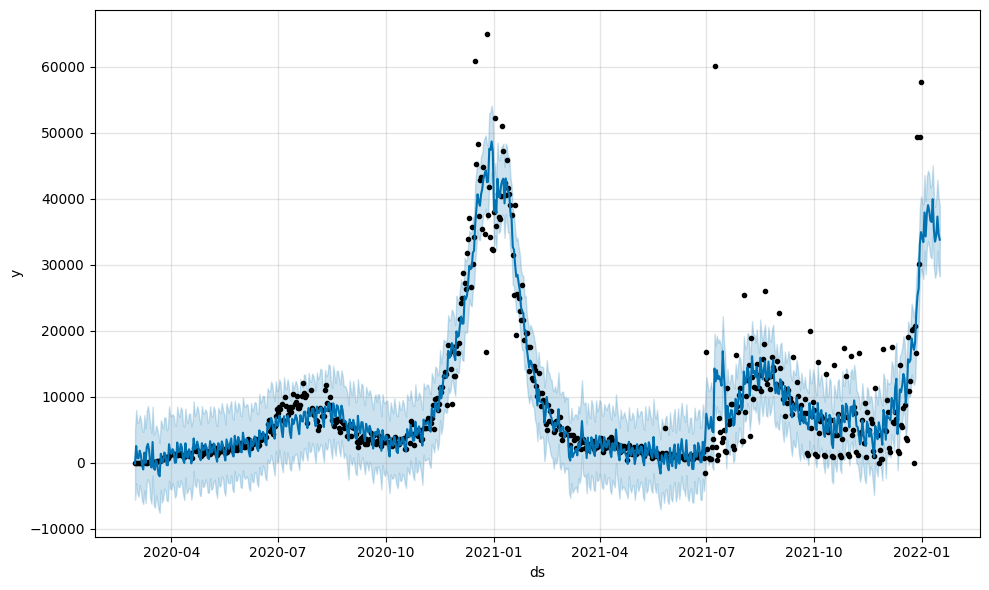

In [28]:
# Make prediction
forecast_multivariate = model_multivariate.predict(future_multivariate)

# Visualize the forecast
model_multivariate.plot(forecast_multivariate); # Add semi-colon to remove the duplicated chart

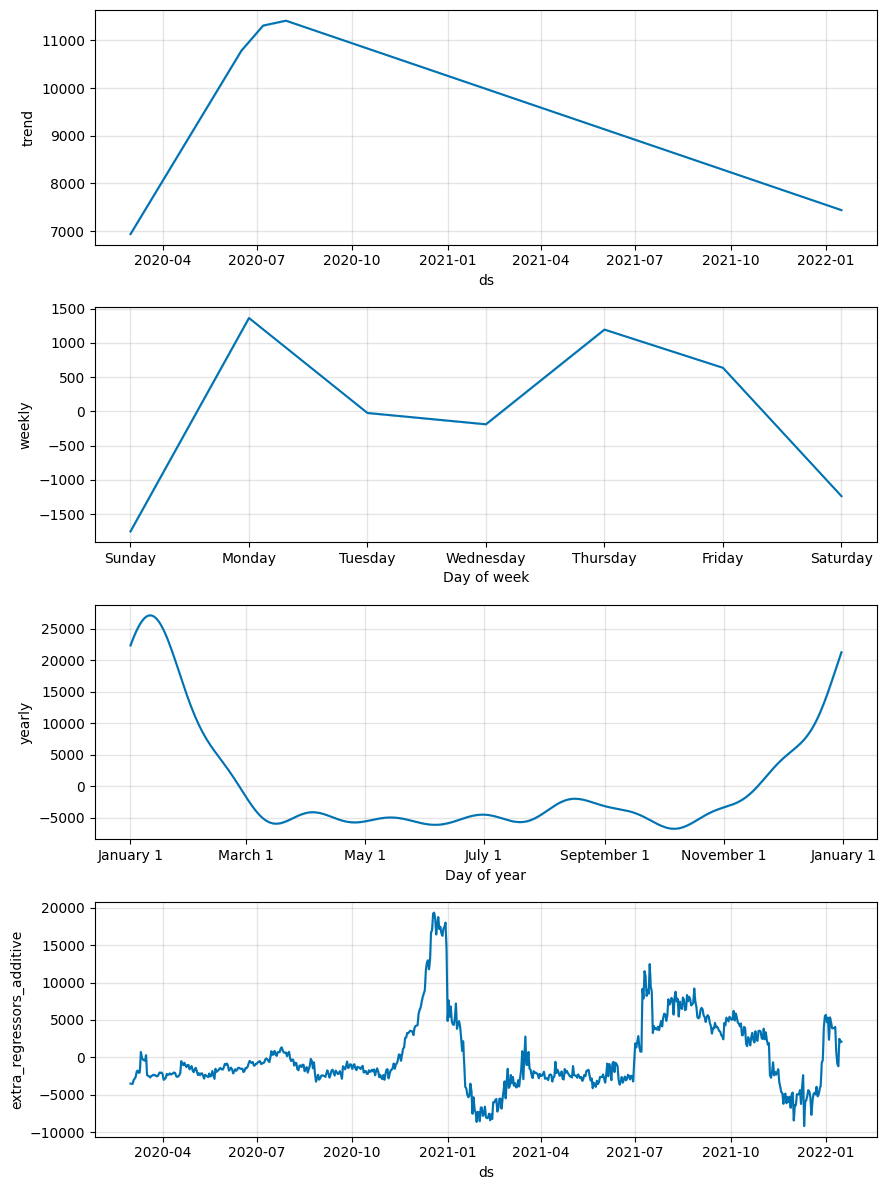

In [29]:
# Visualize the forecast components
model_multivariate.plot_components(forecast_multivariate);

In [31]:
# Merge actual and predicted values
performance_multivariate = pd.merge(test_final, forecast_multivariate[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-16:], on='ds')

# Check MAE value
performance_multivariate_MAE = mean_absolute_error(performance_multivariate['y'], performance_multivariate['yhat'])
print(f'The MAE for the multivariate model is {performance_multivariate_MAE}')

# Check MAPE value
performance_multivariate_MAPE = mean_absolute_percentage_error(performance_multivariate['y'], performance_multivariate['yhat'])
print(f'The MAPE for the multivariate model is {performance_multivariate_MAPE}')

The MAE for the multivariate model is 56236.63735162013
The MAPE for the multivariate model is 9.604736512568496e+18
